<a href="https://colab.research.google.com/github/mavillan/gb-vpp/blob/main/models/gb-vpp-lstm-pl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

!pip install --upgrade kaggle > /dev/null 2>&1
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [ ]:
!pip uninstall -y tensorflow 
!pip install tensorflow==2.4.3 > /dev/null 2>&1

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
Tensorflow version 2.4.3
Running on TPU  ['10.65.217.58:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.65.217.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.65.217.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
!mkdir -p input/
!kaggle competitions download -c ventilator-pressure-prediction -p input/ --force

!unzip -o input/sample_submission.csv.zip -d input/
!unzip -o input/train.csv.zip -d input/
!unzip -o input/test.csv.zip -d input/

 95% 132M/139M [00:01<00:00, 134MB/s]
100% 139M/139M [00:01<00:00, 137MB/s]
 82% 62.0M/75.4M [00:00<00:00, 152MB/s]
100% 75.4M/75.4M [00:00<00:00, 153MB/s]
  0% 0.00/8.50M [00:00<?, ?B/s]
100% 8.50M/8.50M [00:00<00:00, 139MB/s]
Archive:  input/sample_submission.csv.zip
  inflating: input/sample_submission.csv  
Archive:  input/train.csv.zip
  inflating: input/train.csv         
Archive:  input/test.csv.zip
  inflating: input/test.csv          


In [ ]:
!mkdir -p subs/
!kaggle datasets download -d mavillan/gb-vpp-subs -p subs --force --unzip

 79% 42.0M/53.3M [00:00<00:00, 69.2MB/s]
100% 53.3M/53.3M [00:00<00:00, 109MB/s] 


In [ ]:
input_path = "input"
subs_path = "/content/drive/MyDrive/kaggle/gb-vpp/subs"
results_path = "/content/drive/MyDrive/kaggle/gb-vpp/results"
artifacts_path = "/content/drive/MyDrive/kaggle/gb-vpp/artifacts"

In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            35G        1.1G         24G        1.1M        9.6G         33G
Swap:            0B          0B          0B


***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

***
## data preparation

In [ ]:
SEQ_LEN = 80

In [ ]:
train_raw = pd.read_csv(f'{input_path}/train.csv')
test_raw = pd.read_csv(f'{input_path}/test.csv')
submission = pd.read_csv(f'{input_path}/sample_submission.csv')

pseudo_labels = [pd.read_csv(fn) for fn in sorted(glob(f"{results_path}/plabels_lstm_pl_it01_*.csv"))]
print(sorted(glob(f"{results_path}/plabels_lstm_pl_it01_*.csv")))

['/content/drive/MyDrive/kaggle/gb-vpp/results/plabels_lstm_pl_it01_0.csv', '/content/drive/MyDrive/kaggle/gb-vpp/results/plabels_lstm_pl_it01_1.csv', '/content/drive/MyDrive/kaggle/gb-vpp/results/plabels_lstm_pl_it01_2.csv', '/content/drive/MyDrive/kaggle/gb-vpp/results/plabels_lstm_pl_it01_3.csv', '/content/drive/MyDrive/kaggle/gb-vpp/results/plabels_lstm_pl_it01_4.csv']


In [ ]:
PRESSURE_VALUES = np.sort(train_raw.pressure.unique())

PRESSURE_MIN = train_raw.pressure.min()
PRESSURE_MAX = train_raw.pressure.max()
PRESSURE_STEP = PRESSURE_VALUES[1]-PRESSURE_VALUES[0]

def pressure_to_idx(array):
    return ((array - PRESSURE_MIN) / PRESSURE_STEP).astype(int)

def idx_to_pressure(array):
    return (array * PRESSURE_STEP) + PRESSURE_MIN

In [ ]:
mapping = {j:i for i,j in enumerate(train_raw.breath_id.unique())}
train_raw["breath_id"] = train_raw.breath_id.map(mapping)

if SEQ_LEN < 80:

    train_raw = (
        train_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(SEQ_LEN)
        .reset_index(drop=True)
    )
    test_raw = (
        test_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(SEQ_LEN)
        .reset_index(drop=True)
    )

In [ ]:
def compute_feats(df):
    
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()

    df["time_diff"] = df.groupby("breath_id")["time_step"].diff()
    df['vol_diff'] = (df['time_diff']*df['u_in']).fillna(0)
    df['vol_diff_cumsum'] = df.groupby('breath_id')['vol_diff'].cumsum()
    df["time_diff"] = df["time_diff"].fillna(method="bfill")
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] = df['u_in_cumsum'] / (df.groupby("breath_id")["id"].cumcount()+1)
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)

    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']

    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']

    
    # ohe of R&C values
    df['R_cont'] = df['R'].copy()
    df['C_cont'] = df['C'].copy()

    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['RC'] = df['R']+df['C']
    df = pd.get_dummies(df)

    # time features
    df.drop("time_step", axis=1, inplace=True)

    return df

train = compute_feats(train_raw)
test = compute_feats(test_raw)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 53 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   id                         int64  
 1   breath_id                  int64  
 2   u_in                       float64
 3   u_out                      int64  
 4   pressure                   float64
 5   area                       float64
 6   time_diff                  float64
 7   vol_diff                   float64
 8   vol_diff_cumsum            float64
 9   u_in_cumsum                float64
 10  u_in_cummean               float64
 11  u_in_lag1                  float64
 12  u_in_lag2                  float64
 13  u_in_lag3                  float64
 14  u_in_lag4                  float64
 15  u_in_lag_back1             float64
 16  u_in_lag_back2             float64
 17  u_in_lag_back3             float64
 18  u_in_lag_back4             float64
 19  u_out_lag1                 float64
 20  u_

In [ ]:
train_targets = train[['pressure']].to_numpy().reshape(-1, SEQ_LEN)

cols_to_exclude_train = exclude = ["id","breath_id","pressure"]
cols_to_exclude_test = exclude = ["id","breath_id",]

train.drop(cols_to_exclude_train, axis=1, inplace=True)
test.drop(cols_to_exclude_test, axis=1, inplace=True)

In [ ]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

train = train.reshape(-1,SEQ_LEN,train.shape[1])
test =  test.reshape(-1,SEQ_LEN,train.shape[2])

***
## model training

In [ ]:
def build_model(input_dim):
    with tpu_strategy.scope():   
        inputs = layers.Input(shape = input_dim)

        #h1 = layers.Dense(256, activation = 'selu')(inputs)
        #h2 = layers.Dense(512, activation = 'selu')(h1)
        #h3 = layers.Dense(1024, activation = 'swish')(h2)
    
        h1 = layers.Bidirectional(layers.LSTM(1024, return_sequences=True, ))(inputs)
        #h1 = tf.keras.layers.BatchNormalization()(h1)

        h2 = layers.Bidirectional(layers.LSTM(512, return_sequences=True, ))(h1)
        #h2 = tf.keras.layers.BatchNormalization()(h2)

        h3 = layers.Bidirectional(layers.LSTM(256, return_sequences=True, ))(h2)
        #h3 = tf.keras.layers.BatchNormalization()(h3)

        h4 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, ))(h3)
        #h4 = tf.keras.layers.BatchNormalization()(h4)

        out = layers.Dense(128, activation = 'selu')(h4)
        output = layers.Dense(1)(out)

        #out1 = layers.Bidirectional(layers.LSTM(1, return_sequences=True, activation="linear"))(h4)
        #out2 = layers.Bidirectional(layers.LSTM(1, return_sequences=True, activation="linear"))(h4)
        #output = tf.math.reduce_sum(out1 * tf.nn.softmax(out2, axis=-1), axis=-1)
        
        model = keras.Model(inputs, output)
        model.compile(optimizer="adam", loss="mae")
           
    return model    

----------------------------------- Fold: 1 ------------------------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 80, 256)           656384    
_________________________________________________________________
dense (Dense)                (None, 80, 128)           32896     
______________________________________________

None

Epoch 1/300
109/109 [==============================] - 78s 442ms/step - loss: 3.2936 - val_loss: 1.0978
Epoch 2/300
109/109 [==============================] - 21s 195ms/step - loss: 0.7569 - val_loss: 0.5764
Epoch 3/300
109/109 [==============================] - 21s 197ms/step - loss: 0.5413 - val_loss: 0.5045
Epoch 4/300
109/109 [==============================] - 21s 195ms/step - loss: 0.4648 - val_loss: 0.4488
Epoch 5/300
109/109 [==============================] - 21s 195ms/step - loss: 0.4129 - val_loss: 0.4316
Epoch 6/300
109/109 [==============================] - 21s 195ms/step - loss: 0.3881 - val_loss: 0.4264
Epoch 7/300
109/109 [==============================] - 21s 195ms/step - loss: 0.3858 - val_loss: 0.4411
Epoch 8/300
109/109 [==============================] - 21s 196ms/step - loss: 0.3746 - val_loss: 0.4996
Epoch 9/300
109/109 [==============================] - 21s 196ms/step - loss: 0.3749 - val_loss: 0.9161
Epoch 10/300
109/109 [==============================] - 21s 195m

INFO:tensorflow:Assets written to: /content/drive/MyDrive/kaggle/gb-vpp/artifacts/lstm_pl_fold0/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/kaggle/gb-vpp/artifacts/lstm_pl_fold0/assets


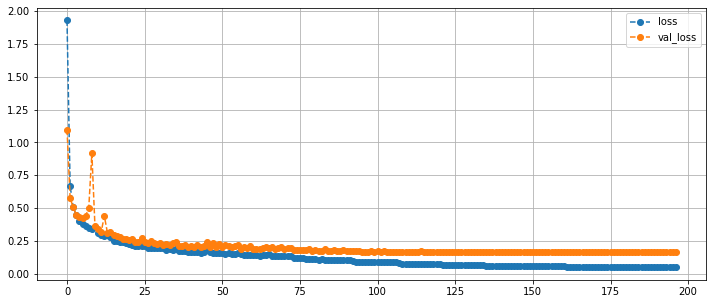

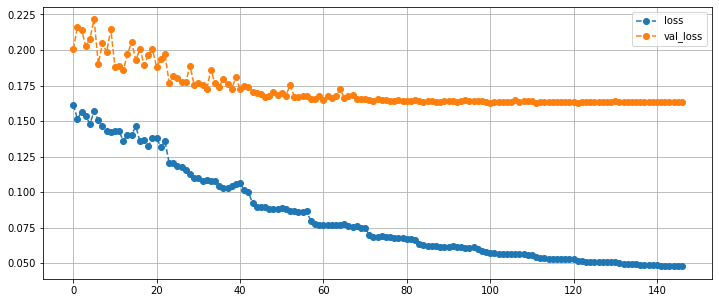

----------------------------------- Fold: 2 ------------------------------------
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 80, 256)           656384    
_________________________________________________________________
dense_2 (Dense)              (None, 80, 128)           32896     
____________________________________________

None

Epoch 1/300
109/109 [==============================] - 75s 433ms/step - loss: 3.2117 - val_loss: 0.7401
Epoch 2/300
109/109 [==============================] - 21s 195ms/step - loss: 0.7046 - val_loss: 0.7946
Epoch 3/300
109/109 [==============================] - 22s 199ms/step - loss: 0.5774 - val_loss: 0.5814
Epoch 4/300
109/109 [==============================] - 21s 195ms/step - loss: 0.4739 - val_loss: 0.5152
Epoch 5/300
109/109 [==============================] - 21s 195ms/step - loss: 0.4557 - val_loss: 0.3972
Epoch 6/300
109/109 [==============================] - 21s 195ms/step - loss: 0.3843 - val_loss: 0.4028
Epoch 7/300
109/109 [==============================] - 21s 195ms/step - loss: 0.3691 - val_loss: 0.3684
Epoch 8/300
109/109 [==============================] - 21s 195ms/step - loss: 0.3691 - val_loss: 0.3857
Epoch 9/300
109/109 [==============================] - 21s 196ms/step - loss: 0.3456 - val_loss: 0.3887
Epoch 10/300
109/109 [==============================] - 21s 196m

INFO:tensorflow:Assets written to: /content/drive/MyDrive/kaggle/gb-vpp/artifacts/lstm_pl_fold1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/kaggle/gb-vpp/artifacts/lstm_pl_fold1/assets


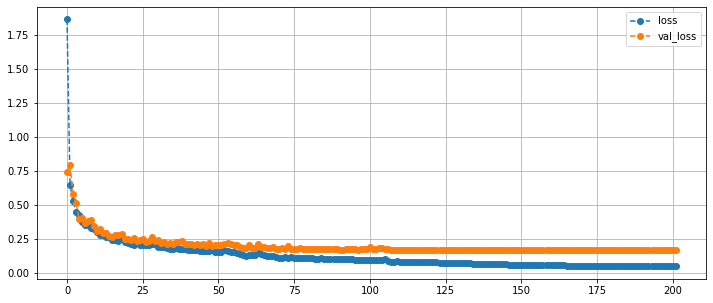

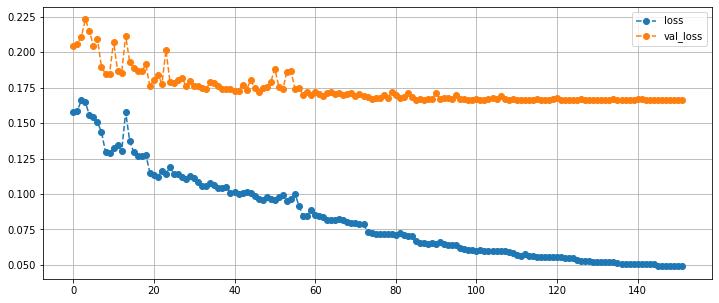

----------------------------------- Fold: 3 ------------------------------------
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 80, 256)           656384    
_________________________________________________________________
dense_4 (Dense)              (None, 80, 128)           32896     
____________________________________________

None

Epoch 1/300
109/109 [==============================] - 78s 434ms/step - loss: 3.2315 - val_loss: 0.9046
Epoch 2/300
109/109 [==============================] - 21s 195ms/step - loss: 0.7613 - val_loss: 0.5958
Epoch 3/300
109/109 [==============================] - 21s 195ms/step - loss: 0.5465 - val_loss: 0.5344
Epoch 4/300
109/109 [==============================] - 21s 195ms/step - loss: 0.4730 - val_loss: 0.5372
Epoch 5/300
109/109 [==============================] - 21s 195ms/step - loss: 0.4367 - val_loss: 0.6397
Epoch 6/300
109/109 [==============================] - 21s 195ms/step - loss: 0.4636 - val_loss: 0.3838
Epoch 7/300
109/109 [==============================] - 21s 195ms/step - loss: 0.3712 - val_loss: 0.4397
Epoch 8/300
109/109 [==============================] - 21s 195ms/step - loss: 0.3624 - val_loss: 0.3634
Epoch 9/300
109/109 [==============================] - 21s 195ms/step - loss: 0.3422 - val_loss: 0.3570
Epoch 10/300
109/109 [==============================] - 21s 195m

INFO:tensorflow:Assets written to: /content/drive/MyDrive/kaggle/gb-vpp/artifacts/lstm_pl_fold2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/kaggle/gb-vpp/artifacts/lstm_pl_fold2/assets


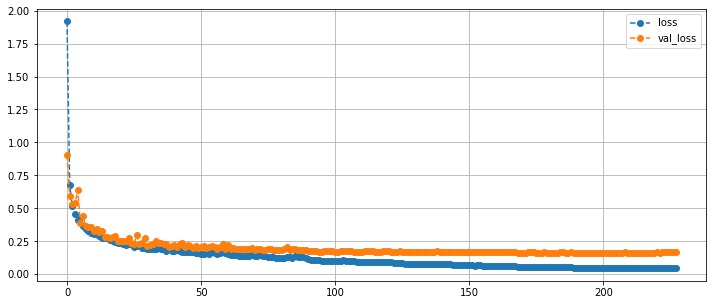

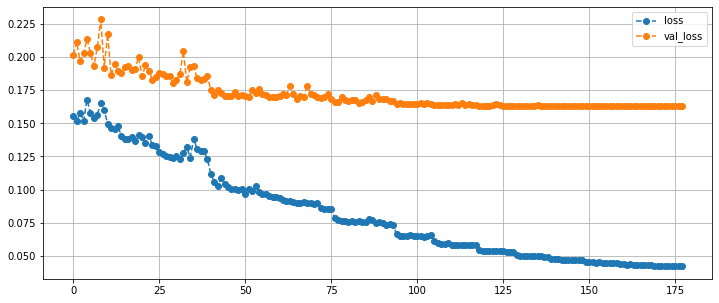

----------------------------------- Fold: 4 ------------------------------------
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 80, 256)           656384    
_________________________________________________________________
dense_6 (Dense)              (None, 80, 128)           32896     
____________________________________________

None

Epoch 1/300
109/109 [==============================] - 78s 439ms/step - loss: 3.2988 - val_loss: 0.9598
Epoch 2/300
109/109 [==============================] - 21s 195ms/step - loss: 0.7169 - val_loss: 0.5603
Epoch 3/300
109/109 [==============================] - 21s 195ms/step - loss: 0.5119 - val_loss: 0.5149
Epoch 4/300
109/109 [==============================] - 21s 195ms/step - loss: 0.4494 - val_loss: 0.5247
Epoch 5/300
109/109 [==============================] - 22s 201ms/step - loss: 0.4232 - val_loss: 0.6607
Epoch 6/300
109/109 [==============================] - 21s 195ms/step - loss: 0.4714 - val_loss: 0.4285
Epoch 7/300
109/109 [==============================] - 21s 195ms/step - loss: 0.3742 - val_loss: 0.4337
Epoch 8/300
109/109 [==============================] - 21s 196ms/step - loss: 0.3543 - val_loss: 0.3609
Epoch 9/300
109/109 [==============================] - 21s 196ms/step - loss: 0.3274 - val_loss: 0.3447
Epoch 10/300
109/109 [==============================] - 21s 196m

INFO:tensorflow:Assets written to: /content/drive/MyDrive/kaggle/gb-vpp/artifacts/lstm_pl_fold3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/kaggle/gb-vpp/artifacts/lstm_pl_fold3/assets


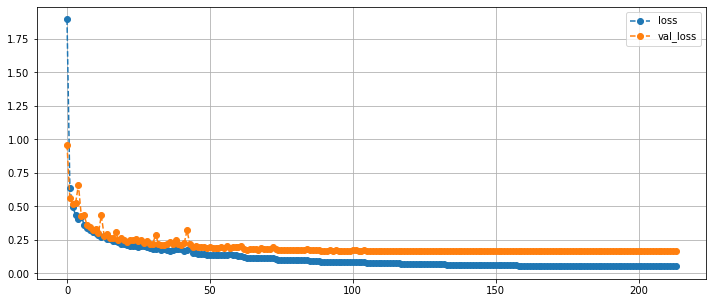

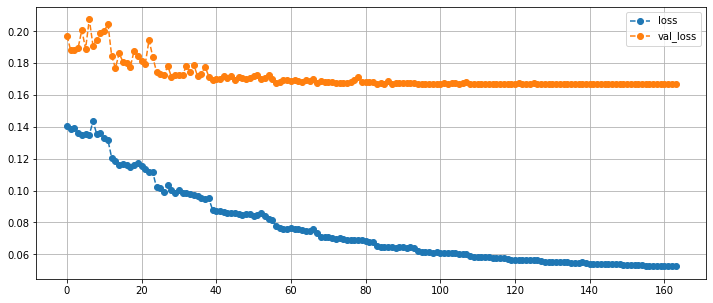

----------------------------------- Fold: 5 ------------------------------------
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 80, 50)]          0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 80, 2048)          8806400   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 80, 1024)          10489856  
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 80, 512)           2623488   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 80, 256)           656384    
_________________________________________________________________
dense_8 (Dense)              (None, 80, 128)           32896     
____________________________________________

None

Epoch 1/300
109/109 [==============================] - 75s 433ms/step - loss: 3.1047 - val_loss: 1.0933
Epoch 2/300
109/109 [==============================] - 22s 203ms/step - loss: 0.7654 - val_loss: 0.6084
Epoch 3/300
109/109 [==============================] - 21s 196ms/step - loss: 0.5672 - val_loss: 0.5236
Epoch 4/300
109/109 [==============================] - 21s 196ms/step - loss: 0.4862 - val_loss: 0.5709
Epoch 5/300
109/109 [==============================] - 21s 196ms/step - loss: 0.4486 - val_loss: 0.4295
Epoch 6/300
109/109 [==============================] - 21s 196ms/step - loss: 0.3928 - val_loss: 0.4139
Epoch 7/300
109/109 [==============================] - 21s 196ms/step - loss: 0.3742 - val_loss: 0.3694
Epoch 8/300
109/109 [==============================] - 21s 196ms/step - loss: 0.3561 - val_loss: 1.1101
Epoch 9/300
109/109 [==============================] - 21s 196ms/step - loss: 0.4814 - val_loss: 0.3460
Epoch 10/300
109/109 [==============================] - 21s 196m

INFO:tensorflow:Assets written to: /content/drive/MyDrive/kaggle/gb-vpp/artifacts/lstm_pl_fold4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/kaggle/gb-vpp/artifacts/lstm_pl_fold4/assets


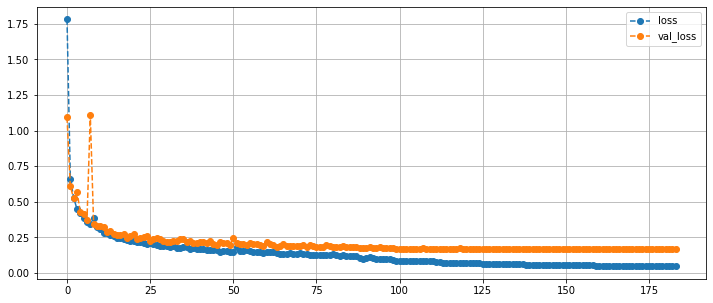

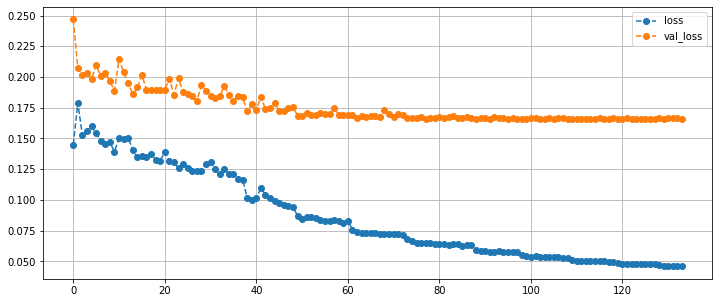

In [ ]:
EPOCH = 300
BATCH_SIZE = 1024

kf = KFold(n_splits=5, shuffle=True, random_state=19)
models_by_fold = list()

oof = train_raw[["id","breath_id","u_out","pressure"]].copy()

for fold, (train_idx,valid_idx) in enumerate(kf.split(train)):

    print(f" Fold: {fold+1} ".center(80, "-"))
    X_train, X_valid = train[train_idx], train[valid_idx]
    y_train, y_valid = train_targets[train_idx], train_targets[valid_idx]

    # PL augmentation
    test_targets = pseudo_labels[fold][['pressure']].to_numpy().reshape(-1, SEQ_LEN)
    X_train = np.concatenate([X_train, test], axis=0)
    y_train = np.concatenate([y_train, test_targets], axis=0)

    #scheduler = ExponentialDecay(
    #    initial_learning_rate=1e-3, 
    #    decay_steps=EPOCH*((len(train)*0.8)/BATCH_SIZE), 
    #    decay_rate=1e-5
    #)
    #lr = LearningRateScheduler(scheduler, verbose=1)
    #lr = OneCycleScheduler(
    #    lr_max = 1e-3,
    #    steps = EPOCH*(X_train.shape[0]/BATCH_SIZE),
    #    phase_1_pct = 0.2,
    #    init_div_factor = 1e1,
    #    final_div_factor = 1e2,
    #)

    lr = ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.75, 
        patience=10, 
        verbose=1
    )
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=35, 
        verbose=1,
        restore_best_weights=True,
    )

    model = build_model(
        input_dim=train.shape[-2:],
    )
    display(model.summary())

    history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_valid, y_valid), 
        epochs=EPOCH, 
        batch_size=BATCH_SIZE, 
        callbacks=[lr,es],
        verbose=1,
    )
    models_by_fold.append(model)

    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    model.save(f"{artifacts_path}/lstm_pl_fold{fold}", options=save_locally)

    # generate the oof predictions
    x_valid_tf = tf.convert_to_tensor(X_valid, dtype=tf.float32)
    oof_preds = model.call(x_valid_tf, training=False).numpy().squeeze()
    idx = oof.query("breath_id in @valid_idx").index
    oof.loc[idx, "pred"] = oof_preds.ravel()

    plt.figure(figsize=(12,5))
    plt.plot(history.history["loss"], "o--", label="loss")
    plt.plot(history.history["val_loss"], "o--", label="val_loss")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    
    plt.figure(figsize=(12,5))
    plt.plot(history.history["loss"][50:], "o--", label="loss")
    plt.plot(history.history["val_loss"][50:], "o--", label="val_loss")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

In [ ]:
print("mae:", oof.eval("abs(pressure - pred)").mean())
print("mae inspiratory:", oof.query("u_out == 0").eval("abs(pressure - pred)").mean())
print("mae expiratory :", oof.query("u_out == 1").eval("abs(pressure - pred)").mean())

mae: 0.1648422117480903
mae inspiratory: 0.17468829015902618
mae expiratory : 0.15881901873804782


lstm_pl_v3 (without leak)
- mae: 0.1663597392500394
- mae inspiratory: 0.17748255839073457
- mae expiratory : 0.1595555189600886

lstm_pl_v2 (with leak)
- mae: 0.1584655923419512
- mae inspiratory: 0.17314587587616617
- mae expiratory : 0.1494851457644678

lstm_pl_v1 (with leak)
- mae: 0.15838549821684894
- mae inspiratory: 0.17731654175485345
- mae expiratory : 0.14680471200411457

***
## sub generation

In [ ]:
all_preds = list()
test_tf = tf.convert_to_tensor(test, dtype=tf.float32)

for model in models_by_fold:
    preds = model.call(test_tf, training=False).numpy().squeeze().ravel()
    all_preds.append(preds)

test_raw["pressure"] = np.median(all_preds, axis=0)

In [ ]:
# saves final sub
sub = pd.merge(submission["id"], test_raw[["id","pressure"]], how="left", on="id")
sub["pressure"] = sub["pressure"].fillna(0)
sub.to_csv(f"{subs_path}/sub_lstm_pl.csv", index=False)

# clip predictions to discrete values
all_pressure = np.sort(train_raw.pressure.unique())
PRESSURE_MIN = all_pressure[0]
PRESSURE_MAX = all_pressure[-1]
PRESSURE_STEP = all_pressure[1]-all_pressure[0]

sub["pressure"] =\
    np.round( (sub.pressure - PRESSURE_MIN)/PRESSURE_STEP ) * PRESSURE_STEP + PRESSURE_MIN
sub.pressure = np.clip(sub.pressure, PRESSURE_MIN, PRESSURE_MAX)
sub.to_csv(f"{subs_path}/sub_lstm_pl_clip.csv", index=False)

In [ ]:
# saves oof preds
oof.to_csv(f"{results_path}/oof_lstm_pl.csv", index=False)

In [ ]:
# saves each model preds (pseudo labels)
for fold,preds in enumerate(all_preds):
    _sub = submission.copy()
    _test = test_raw[["id","pressure"]].copy()
    _test["pressure"] = preds
    _sub = pd.merge(_sub["id"], _test[["id","pressure"]], how="left", on="id")
    _sub["pressure"] = _sub["pressure"].fillna(0)
    _sub.to_csv(f"{results_path}/plabels_lstm_pl_{fold}.csv", index=False)

***